In [164]:
from skfin.datasets_ import load_kf_returns
import pandas as pd
import numpy as np

# ------------------------------
# FF + MOMENTUM
# ------------------------------
ff = load_kf_returns(filename="F-F_Research_Data_Factors")["Monthly"].copy()
mom = load_kf_returns(filename="F-F_Momentum_Factor")["Monthly"].copy()

ff.index  = pd.to_datetime(ff.index,  format="%Y%m")
mom.index = pd.to_datetime(mom.index, format="%Y%m")
ff.columns  = ff.columns.str.strip()
mom.columns = mom.columns.str.strip()

# Identifier automatiquement la colonne momentum (Mom / MOM / Mom   )
mom_col = [c for c in mom.columns if c.lower().startswith("mom")][0]

# Fusion propre
factors = (
    ff[["Mkt-RF", "SMB", "HML", "RF"]]
    .join(mom.rename(columns={mom_col: "Momentum"})[["Momentum"]], how="inner")
).rename(columns={
    "SMB":  "Size",
    "HML":  "Value",
})

# Convertir en décimal
ret_cols = ["Mkt-RF", "Size", "Value", "RF", "Momentum"]
factors[ret_cols] = factors[ret_cols] / 100

# Marché total = excès + RF
factors["Mkt"] = factors["Mkt-RF"] + factors["RF"]

# Spreads facteur – Mkt
for s in ["Momentum", "Size", "Value"]:
    factors[f"{s}_minus_Mkt"] = factors[s] - factors["Mkt"]

# On garde à partir de 1963
factors = factors[factors.index >= "1980-01-01"].copy()
print("Facteurs FF+MOM :", factors.shape)


Facteurs FF+MOM : (548, 9)


In [165]:
# --- Load main dataset (FRED-MD monthly macro data) ---
url_data = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/2025-09-MD.csv"
fred = pd.read_csv(url_data, index_col=0)

# --- Separate transformation "tcodes" (first row) and actual data (remaining rows) ---
fred_data = fred.iloc[1:,:].copy()
fred_code = fred.iloc[0,:].copy()

# --- Convert index to datetime ---
fred_data.index = pd.to_datetime(fred_data.index, infer_datetime_format=True)
print(fred_data.info())

# --- Drop variables with too many missing values ---
cols_to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "UMCSENTx", "ANDENOx"]
fred_data = fred_data.drop(columns=cols_to_drop, errors="ignore").copy()

# --- Function: count consecutive NaN values at the end of a series ---
def trailing_nans(s: pd.Series) -> int:
    """Count the number of consecutive NaN values at the end of a Series."""
    if not s.isna().any():
        return 0
    return int(np.argmax(~s[::-1].isna().values)) if s.isna().any() else 0

# --- Identify variables with trailing NaNs ---
nan_trails = {col: trailing_nans(fred_data[col]) for col in fred_data.columns}
nan_trails = {k: v for k, v in nan_trails.items() if v > 0}

# --- Shift series forward by 'n' months if they have n trailing NaNs ---
for col, lag in nan_trails.items():
    if lag > 0:
        fred_data[col] = fred_data[col].shift(lag)

# --- Restrict the sample to ensure consistent coverage across variables ---
fred_data = fred_data.loc[fred_data.index >= "1962-05-01"]

print(f"\nFinal dataset size: {fred_data.shape[0]} observations, {fred_data.shape[1]} variables")


# --- Normalize column names to ensure alignment between data and codes ---
fred_data.columns = fred_data.columns.str.upper()
# fred_code is a single-row DataFrame or a Series with tcodes per column
tcode_map = fred_code.squeeze()                    # to Series if single row
tcode_map.index = tcode_map.index.str.upper()      # align names
tcode_map = pd.to_numeric(tcode_map, errors="coerce")

# --- Container for transformed series ---
df_transformed = pd.DataFrame(index=fred_data.index)

# --- Apply McCracken–Ng tcodes where available; otherwise keep series as is ---
for col in fred_data.columns:
    s = fred_data[col]
    code = tcode_map.get(col, np.nan)  # NaN => no code available

    if pd.isna(code):
        # No transformation code: keep original series
        s_tr = s
    else:
        code = int(code)
        if code == 1:
            s_tr = s
        elif code == 2:
            s_tr = s.diff()
        elif code == 3:
            s_tr = s.diff().diff()
        elif code == 4:
            # Log of levels; guard against non-positive values
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr)
        elif code == 5:
            # First difference of log (approximate growth rate)
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff()
        elif code == 6:
            # Second difference of log
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff().diff()
        else:
            # Δ(x_t / x_{t-1} - 1)
            r = s / s.shift(1) - 1
            s_tr = r.diff()

    df_transformed[col] = s_tr


# List of selected variables
cols_bis = [ "M2SL", "FEDFUNDS", "T1YFFM", "T5YFFM", "T10YFFM", "AAAFFM",
    "BAAFFM", "OILPRICEX", "CPIAUCSL",
    "S&P 500", "S&P DIV YIELD", "S&P PE RATIO", "VIXCLSX"
]

# Extract the reduced dataset
df_bis = df_transformed[cols_bis].copy()

# Overview of dimensions and sample rows
print(df_bis.shape)
df_bis.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 1959-01-01 to 2025-08-01
Columns: 126 entries, RPI to VIXCLSx
dtypes: float64(102), int64(24)
memory usage: 793.8 KB
None

Final dataset size: 760 observations, 122 variables
(760, 13)


/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_18036/1556670574.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_18036/1556670574.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_18036/1556670574.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

,M2SL,FEDFUNDS,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,OILPRICEX,CPIAUCSL,S&P 500,S&P DIV YIELD,S&P PE RATIO,VIXCLSX
sasdate,,,,,,,,,,,,,
1962-05-01,NaN,NaN,0.67,1.30,1.51,1.92,2.64,NaN,NaN,NaN,NaN,NaN,NaN
1962-06-01,NaN,0.32,0.35,0.96,1.23,1.60,2.34,NaN,NaN,-0.124253,0.105335,-0.084937,NaN
1962-07-01,-0.000881,0.03,0.58,1.09,1.30,1.63,2.34,0.0,0.001324,0.023802,0.252174,-0.133255,19.5715
1962-08-01,0.001400,0.22,0.27,0.78,1.05,1.42,2.13,0.0,0.001653,0.026844,0.443267,0.010199,15.7942
1962-09-01,0.000250,-0.03,0.16,0.80,1.08,1.42,2.13,0.0,0.002629,-0.008926,-0.075392,0.016086,18.3148


In [166]:
# ============================================================
# 1) COPY — On part de df_bis déjà transformé (FRED-MD tcodes)
# ============================================================
macro = df_bis.copy()

# ==============================
# 2) Z-SCORES (rolling)
# ==============================
ROLL_Z = 24    # 24 mois ~ 2 ans : standard en macro-finance

macro_z = (macro - macro.rolling(ROLL_Z).mean()) / macro.rolling(ROLL_Z).std()
macro_z.columns = [c + "_Z" for c in macro.columns]

# ==============================
# 3) FEATURES POLYNOMIALES
# ==============================
macro_poly2 = macro.pow(2).add_prefix("SQ_")          # x²
macro_poly3 = macro.pow(3).add_prefix("CUBE_")        # x³

# ==============================
# 4) EMA (exponential moving avg)
# ==============================
EMA_SPANS = [2, 3, 6]

macro_ema = pd.DataFrame(index=macro.index)
for span in EMA_SPANS:
    ema_tmp = macro.ewm(span=span, adjust=False).mean()
    ema_tmp.columns = [f"{c}_EMA{span}" for c in macro.columns]
    macro_ema = pd.concat([macro_ema, ema_tmp], axis=1)

# ==============================
# 5) Rolling Volatility & Rolling Slope (linear trend)
# ==============================
ROLL_WINDOW = 12

macro_rollvol = macro.rolling(ROLL_WINDOW).std().add_prefix("VOL_")

# Rolling slope via regression sur rolling window
def rolling_slope(x, window=ROLL_WINDOW):
    idx = np.arange(window)
    coefs = []
    for i in range(window, len(x)+1):
        y = x[i-window:i]
        if y.isna().any():
            coefs.append(np.nan)
            continue
        # slope via OLS closed-form
        beta = np.cov(idx, y)[0,1] / np.var(idx)
        coefs.append(beta)
    return pd.Series([np.nan]*(window-1) + coefs, index=x.index)

macro_slope = pd.DataFrame(index=macro.index)
for c in macro.columns:
    macro_slope[c + "_SLOPE"] = rolling_slope(macro[c])

# ==============================
# 7) Assemblage final sans lookahead
# ==============================
X_macro_enriched = pd.concat([
    macro,
    macro_z,
    macro_poly2,
    macro_ema,
    macro_slope
], axis=1)

# Remplissage propre (uniquement forward-fill)
macro = X_macro_enriched.fillna(method="ffill").dropna()

print("Shape enriched macro :", X_macro_enriched.shape)


Shape enriched macro : (760, 91)


In [167]:
# Alignement index macro ∩ facteurs
common_idx = factors.index.intersection(macro.index)
common_idx = common_idx[common_idx >= pd.Timestamp("1963-01-01")]

ff_fac = factors.loc[common_idx].copy()

print("Macro :", macro.shape)
print("Facteurs :", ff_fac.shape)


Macro : (734, 91)
Facteurs : (548, 9)


In [168]:
r_jm = ff_fac["Momentum_minus_Mkt"].dropna()
r_jm = r_jm.loc[common_idx]     # sécurité alignement

print("Spread JM :", r_jm.index.min(), "→", r_jm.index.max(), "(", len(r_jm), ")")


X_cluster = pd.DataFrame(index=common_idx)

# rolls / EWMs comme dans le papier
for span in (1, 2, 3):
    X_cluster[f"Momentum_minus_Mkt_ewm{span}"] = r_jm.ewm(span=span, adjust=False).mean()

X_cluster["Momentum_minus_Mkt_vol3"] = r_jm.rolling(3).std()

X_cluster = X_cluster.dropna()
r_jm = r_jm.loc[X_cluster.index]


Spread JM : 1980-01-01 00:00:00 → 2025-08-01 00:00:00 ( 548 )


In [169]:
X_forecast = pd.concat(
    [
        macro,   # données macro
    ],
    axis=1
)

X_forecast = X_forecast.loc[X_cluster.index].dropna()

# Réaligner tout
idx_final = X_forecast.index
X_cluster = X_cluster.loc[idx_final]
r_jm      = r_jm.loc[idx_final]

print("X_forecast :", X_forecast.shape)
print("Index final :", idx_final.min(), "→", idx_final.max(), "(", len(idx_final), ")")


X_forecast : (546, 91)
Index final : 1980-03-01 00:00:00 → 2025-08-01 00:00:00 ( 546 )


In [170]:
import numpy as np
import pandas as pd
import ruptures as rpt

def jm_monthly(r: pd.Series, spans=(1, 2, 3), pen: float = 10.0) -> pd.Series:
    """
    Jensen–Ma regime segmentation on monthly returns.
    Inputs:
        r     : pd.Series of factor spread returns (e.g., Momentum − Market)
        spans : list of EWM spans used as features for segmentation
        pen   : penalty λ of the PELT algorithm
    Output:
        pd.Series of regime labels (0/1)
    """

    # --- Clean & prepare ---
    r = r.dropna()
    feat = pd.DataFrame(index=r.index)

    # --- EWM features (signal extraction) ---
    for s in spans:
        feat[f"ewm{s}"] = r.ewm(span=s, adjust=False).mean()

    feat = feat.dropna()
    r_aligned = r.loc[feat.index]

    # --- Matrix for ruptures ---
    X = feat.values

    # --- PELT segmentation ---
    algo = rpt.Pelt(model="l2").fit(X)
    bkpts = algo.predict(pen=pen)

    # --- Assign regime label per segment ---
    labels = np.zeros(len(r_aligned), dtype=int)
    start = 0

    for b in bkpts:
        seg_mean = r_aligned.iloc[start:b].mean()
        labels[start:b] = 1 if seg_mean > 0 else 0
        start = b

    return pd.Series(labels, index=r_aligned.index, name="jm_regime")



===== BEST OVERALL =====
λ* : 0.0
Best XGB params : {'max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 150, 'subsample': 1.0, 'colsample_bytree': 0.8, 'scale_pos_weight': 1}
sharpe_test                                                 1.110276
best_xgb_params    {'max_depth': 2, 'learning_rate': 0.05, 'n_est...
Name: 0.0, dtype: object

Sharpe TRAIN : 1.6078882591540318
Sharpe TEST  : 1.1102755041266674


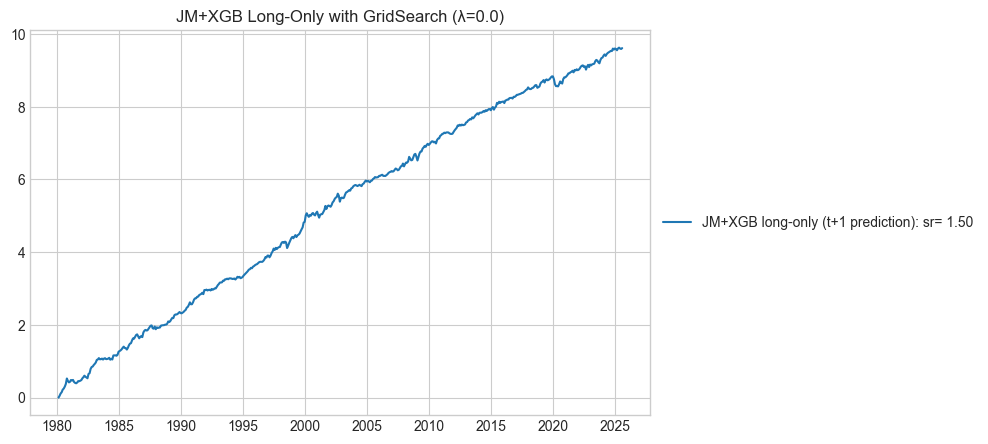

In [171]:
from skfin.backtesting_with_cost import compute_pnl_components
from skfin.metrics import sharpe_ratio
from skfin.plot import line
from xgboost import XGBClassifier
import itertools
import numpy as np
import pandas as pd

# ==============================
# Définition r_factor, r_mkt
# ==============================
r_factor = ff_fac["Momentum"].loc[idx_final]
r_mkt    = ff_fac["Mkt"].loc[idx_final]

ret_2assets = pd.concat(
    [r_factor.rename("Momentum"), r_mkt.rename("Market")],
    axis=1
)

vol_liq_all = ret_2assets.rolling(3).std().bfill()

# ==============================
# Split train/test
# ==============================
TRAIN_END = pd.Timestamp("2016-01-01")

r_train = r_jm.loc[r_jm.index < TRAIN_END]
r_test  = r_jm.loc[r_jm.index >= TRAIN_END]

X_train = X_forecast.loc[r_jm.index < TRAIN_END]
X_test  = X_forecast.loc[r_jm.index >= TRAIN_END]

JM_SPANS = (1,2,3)
lambda_grid = np.round(np.arange(0.0, 20.0, 2), 2)

# === Grid hyperparamètres XGBoost ===
xgb_param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.05],
    "n_estimators": [150, 250],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.6, 0.8],
    "scale_pos_weight": [1, 2, 3, 5],
}
xgb_param_list = list(itertools.product(*xgb_param_grid.values()))


# ============================================================
# FUSION : GRID JM + GRID XGB
# ============================================================
results = []

for lam in lambda_grid:

    # --- JM(t)
    reg_train_t = jm_monthly(r_train, spans=JM_SPANS, pen=lam).dropna()

    # --- JM(t+1)
    reg_train_tplus1 = reg_train_t.shift(-1).dropna()

    common_idx_tr = X_train.index.intersection(reg_train_tplus1.index)
    X_tr = X_train.loc[common_idx_tr]
    y_tr = reg_train_tplus1.loc[common_idx_tr].astype(int)

    if len(y_tr.unique()) < 2:
        continue

    # Best allocation pour ce λ
    mean_by_reg = r_train.loc[reg_train_t.index].groupby(reg_train_t).mean()
    best_label = mean_by_reg.idxmax()

    alloc_map = {lbl: (1.0, 0.0) if lbl==best_label else (0.0,1.0)
                 for lbl in y_tr.unique()}

    # ==== GRID XGB ====
    best_sh_xgb = -999
    best_xgb_params = None

    for params in xgb_param_list:

        params_dict = dict(zip(xgb_param_grid.keys(), params))
        clf = XGBClassifier(
            **params_dict,
            n_jobs=-1,
            random_state=0,
            objective="binary:logistic",
            eval_metric="logloss"
        )

        clf.fit(X_tr, y_tr)

        # prédiction t+1
        proba_test_tplus1 = clf.predict_proba(X_test)[:,1]
        reg_pred_tplus1 = pd.Series((proba_test_tplus1 > 0.5).astype(int),
                                    index=X_test.index)

        # Holdings
        h_train = pd.DataFrame(0.0, index=y_tr.index, columns=["Momentum","Market"])
        for lbl in y_tr.unique():
            h_train.loc[y_tr==lbl] = alloc_map[lbl]

        h_test = pd.DataFrame(0.0, index=reg_pred_tplus1.index, columns=["Momentum","Market"])
        for lbl in y_tr.unique():
            h_test.loc[reg_pred_tplus1==lbl] = alloc_map[lbl]

        h_all = pd.concat([h_train, h_test]).sort_index()

        pnl_comp = compute_pnl_components(
            h_all,
            ret_2assets.loc[h_all.index],
            vol_liquidity_factor=vol_liq_all.loc[h_all.index]
        )
        pnl_gross_all = pnl_comp["gross"]

        pnl_gross_test = pnl_gross_all.loc[r_test.index.intersection(pnl_gross_all.index)]
        sh_test = sharpe_ratio(pnl_gross_test)

        if sh_test > best_sh_xgb:
            best_sh_xgb = sh_test
            best_xgb_params = params_dict

    # Résultat pour ce λ
    results.append({
        "lambda": lam,
        "sharpe_test": best_sh_xgb,
        "best_xgb_params": best_xgb_params
    })

# Résultats en DataFrame
df_res = pd.DataFrame(results).set_index("lambda")
best_lambda = df_res["sharpe_test"].idxmax()
best_xgb_params = df_res.loc[best_lambda, "best_xgb_params"]

print("\n===== BEST OVERALL =====")
print("λ* :", best_lambda)
print("Best XGB params :", best_xgb_params)
print(df_res.loc[best_lambda])


# ============================================================
# RE-ENTRAINEMENT FINAL AVEC λ* ET XGB*
# ============================================================

# JM final train
reg_train_t = jm_monthly(r_train, spans=JM_SPANS, pen=best_lambda).dropna()
reg_train_tplus1 = reg_train_t.shift(-1).dropna()

common_idx_best = X_train.index.intersection(reg_train_tplus1.index)
X_tr_best = X_train.loc[common_idx_best]
y_tr_best = reg_train_tplus1.loc[common_idx_best].astype(int)

# Allocation finale
mean_by_reg_best = r_train.loc[reg_train_t.index].groupby(reg_train_t).mean()
best_label_best = mean_by_reg_best.idxmax()
alloc_map_best = {lbl: (1.0,0.0) if lbl==best_label_best else (0.0,1.0)
                  for lbl in y_tr_best.unique()}

# XGB final
clf_best = XGBClassifier(
    **best_xgb_params,
    n_jobs=-1,
    random_state=0,
    objective="binary:logistic",
    eval_metric="logloss"
)
clf_best.fit(X_tr_best, y_tr_best)

# Prédiction test (t+1)
proba_test_best = clf_best.predict_proba(X_test)[:, 1]
reg_pred_test_best = pd.Series((proba_test_best > 0.5).astype(int),
                               index=X_test.index)

# Holdings final
h_train_best = pd.DataFrame(0.0, index=y_tr_best.index,
                            columns=["Momentum","Market"])
for lbl in y_tr_best.unique():
    h_train_best.loc[y_tr_best==lbl] = alloc_map_best[lbl]

h_test_best = pd.DataFrame(0.0, index=reg_pred_test_best.index,
                           columns=["Momentum","Market"])
for lbl in y_tr_best.unique():
    h_test_best.loc[reg_pred_test_best==lbl] = alloc_map_best[lbl]

h_all_best = pd.concat([h_train_best, h_test_best]).sort_index()

# PnL final
pnl_comp_best = compute_pnl_components(
    h_all_best,
    ret_2assets.loc[h_all_best.index],
    vol_liquidity_factor=vol_liq_all.loc[h_all_best.index]
)

pnl_gross_all = pnl_comp_best["gross"]

train_idx = r_train.index.intersection(pnl_gross_all.index)
test_idx  = r_test.index.intersection(pnl_gross_all.index)

pnl_train = pnl_gross_all.loc[train_idx]
pnl_test  = pnl_gross_all.loc[test_idx]

print("\nSharpe TRAIN :", sharpe_ratio(pnl_train))
print("Sharpe TEST  :", sharpe_ratio(pnl_test))

# Courbe cumulée
line(
    pnl_gross_all.rename("JM+XGB long-only (t+1 prediction)"),
    cumsum=True,
    legend_sharpe_ratio=True,
    title=f"JM+XGB Long-Only with GridSearch (λ={best_lambda})"
)


In [172]:
import matplotlib as plt


=== XGB — CLASSIFICATION METRICS ===
              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82        85
         1.0       0.45      0.30      0.36        30

    accuracy                           0.72       115
   macro avg       0.61      0.59      0.59       115
weighted avg       0.69      0.72      0.70       115

Accuracy : 0.7217391304347827
Balanced Accuracy : 0.5852941176470589
ROC-AUC : 0.6094117647058822


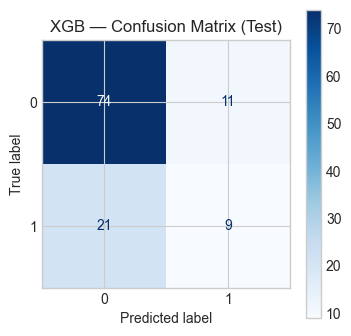

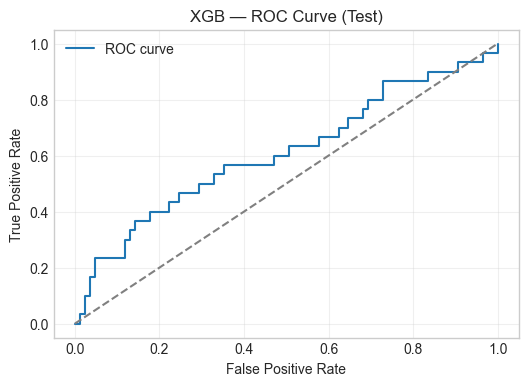


=== SKFIN PERFORMANCE ===
Sharpe : 1.5021941515737633

=== SKFIN PERFORMANCE ===
Sharpe : 1.1102755041266674


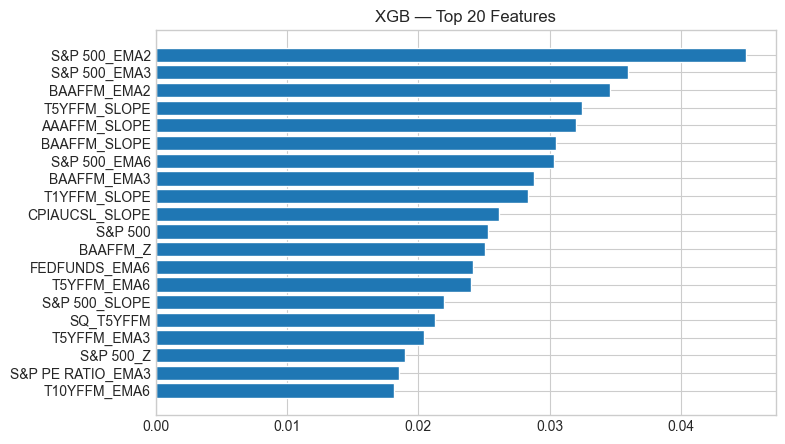

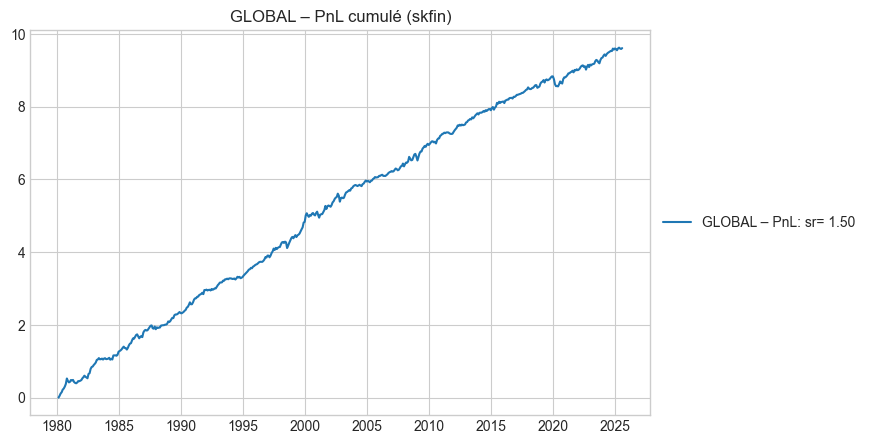

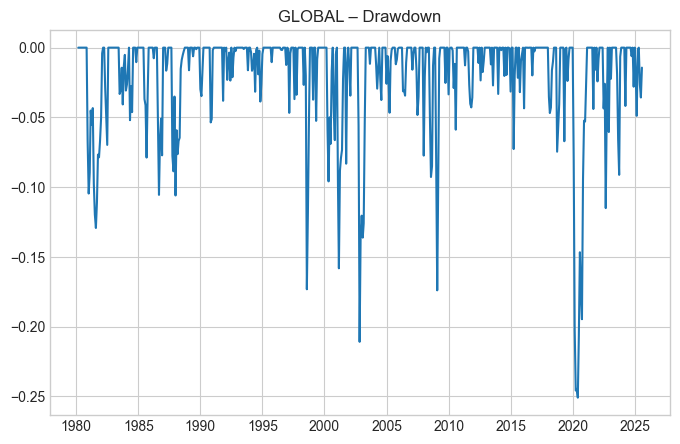

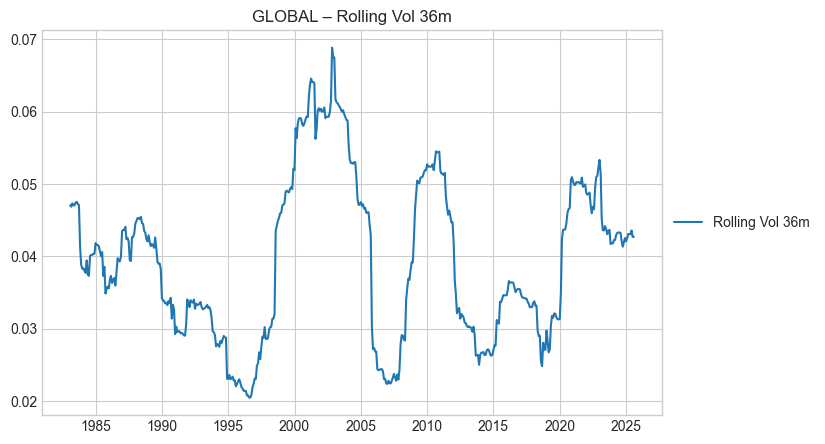

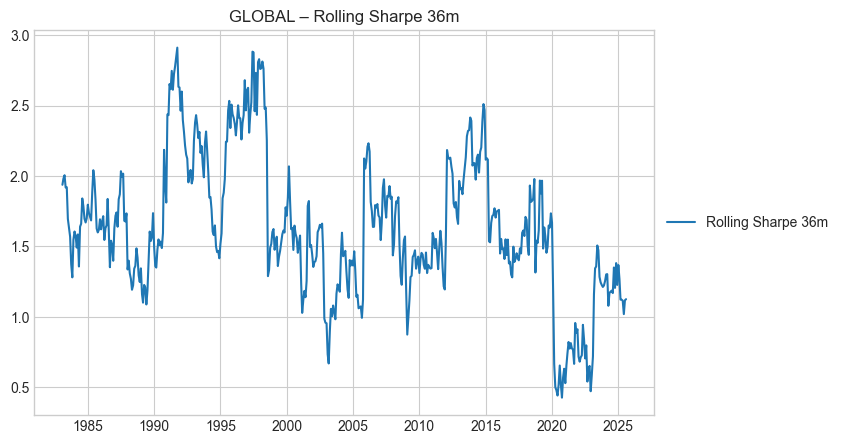

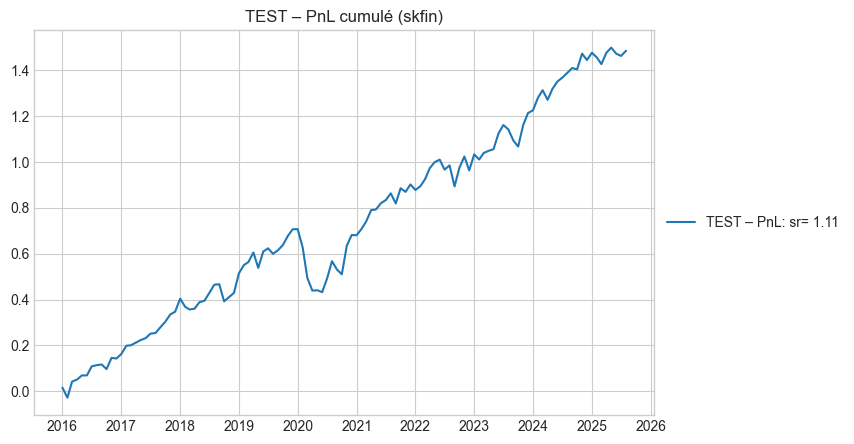

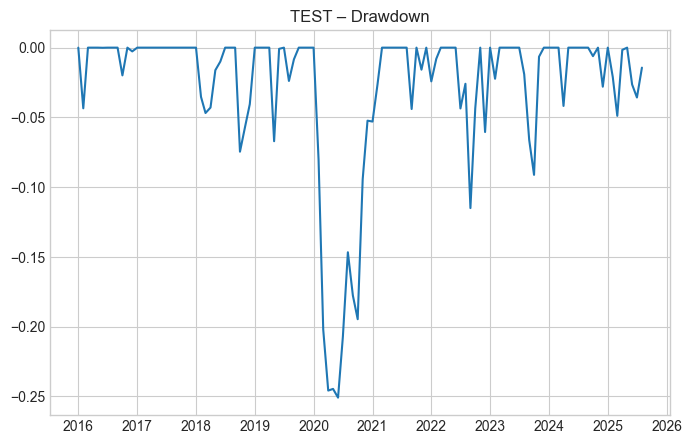

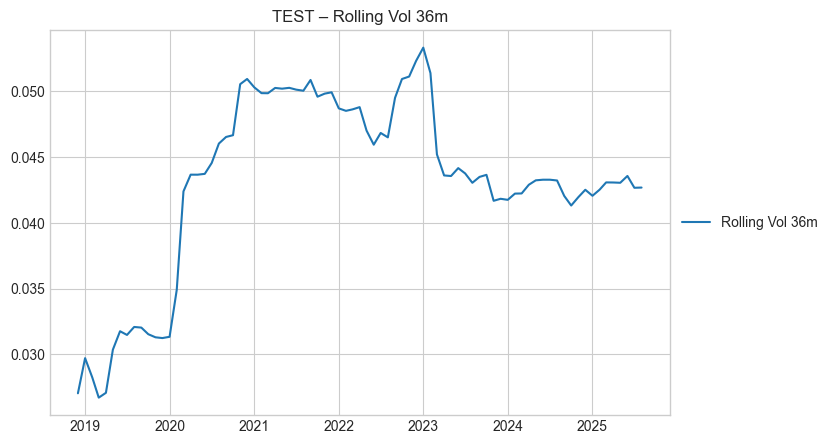

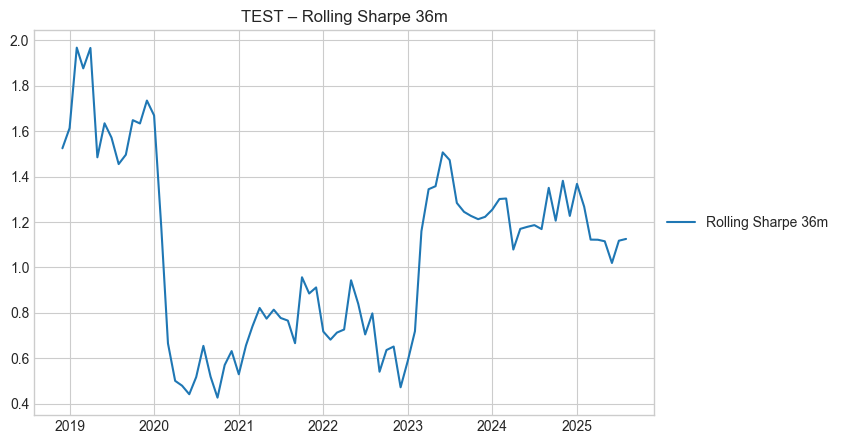

In [173]:
# ============================================================
# 1) Vérité terrain : JM(t+1) sans lookahead
# ============================================================

# Régimes JM(t) sur toute la série r_jm
reg_all_t = jm_monthly(r_jm, spans=JM_SPANS, pen=best_lambda).dropna()

# Régimes JM(t+1)
reg_all_tplus1 = reg_all_t.shift(-1).dropna()

# Index test compatibles (évite KeyError)
common_test_idx = r_test.index.intersection(reg_all_tplus1.index)

# Vérité terrain t+1
reg_test_true = reg_all_tplus1.loc[common_test_idx]

# Adapter prédictions test (mêmes dates)
reg_pred_test_best = reg_pred_test_best.loc[common_test_idx]
proba_test_best = pd.Series(proba_test_best, index=X_test.index).loc[common_test_idx]


from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

def xgb_performance_report(y_true, y_pred, y_proba):

    print("\n=== XGB — CLASSIFICATION METRICS ===")
    print(classification_report(y_true, y_pred))

    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Balanced Accuracy :", balanced_accuracy_score(y_true, y_pred))
    print("ROC-AUC :", roc_auc_score(y_true, y_proba))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4,4))
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, cmap="Blues")
    ax.set_title("XGB — Confusion Matrix (Test)")
    plt.show()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label="ROC curve")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.title("XGB — ROC Curve (Test)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ============================================================
# 3) Feature importance
# ============================================================
def xgb_feature_importance(clf, X_train, top=20):
    from skfin.plot import bar
    imp = pd.Series(clf.feature_importances_, index=X_train.columns)
    imp = imp.sort_values(ascending=False).head(top)
    bar(
        imp,
        title=f"XGB — Top {top} Features",
        horizontal=True
    )


# ============================================================
# 4) Analyse PnL via SKFIN (Sharpe, Drawdown, Rolling)
# ============================================================
from skfin.plot import line
from skfin.metrics import sharpe_ratio

def skfin_pnl_analysis(pnl, title_prefix="Strategy"):

    print("\n=== SKFIN PERFORMANCE ===")
    print("Sharpe :", sharpe_ratio(pnl))

    # Cumulated PnL
    line(
        pnl.rename(f"{title_prefix} – PnL"),
        cumsum=True,
        legend_sharpe_ratio=True,
        title=f"{title_prefix} – PnL cumulé (skfin)"
    )

    # Drawdown
    cum = (1 + pnl).cumprod()
    dd = cum / cum.cummax() - 1
    line(
        dd.rename(f"{title_prefix} – Drawdown"),
        title=f"{title_prefix} – Drawdown",
        legend=False
    )

    # Rolling stats
    roll_vol = pnl.rolling(36).std()
    line(
        roll_vol.rename("Rolling Vol 36m"),
        title=f"{title_prefix} – Rolling Vol 36m"
    )
    roll_sharpe = pnl.rolling(36).apply(sharpe_ratio)
    line(
        roll_sharpe.rename("Rolling Sharpe 36m"),
        title=f"{title_prefix} – Rolling Sharpe 36m"
    )


# ============================================================
# 5) MASTER: Analyse complète SKFIN + XGB
# ============================================================
def full_strategy_diagnostics_skfin(
    r_jm,
    reg_train_t,
    reg_test_true,
    reg_pred_test,
    reg_pred_proba,
    clf,
    pnl_gross_all,
    pnl_gross_test,
    X_train,
):
    # --- XGB ---
    xgb_performance_report(reg_test_true, reg_pred_test, reg_pred_proba)
    xgb_feature_importance(clf, X_train)

    # --- PnL global ---
    skfin_pnl_analysis(pnl_gross_all, title_prefix="GLOBAL")

    # --- PnL test ---
    skfin_pnl_analysis(pnl_gross_test, title_prefix="TEST")


# ============================================================
# 6) APPEL FINAL (tout roule)
# ============================================================

# Important : reg_train_t = JM(t) sur train (déjà calculé dans ton code)
full_strategy_diagnostics_skfin(
    r_jm=r_jm,
    reg_train_t=reg_train_t,           # JM(t) train
    reg_test_true=reg_test_true,       # JM(t+1) test
    reg_pred_test=reg_pred_test_best,  # XGB prédiction(t+1)
    reg_pred_proba=proba_test_best,    # proba XGB(t+1)
    clf=clf_best,                      # XGB final
    pnl_gross_all=pnl_gross_all,       # PnL total skfin
    pnl_gross_test=pnl_test,           # PnL test skfin
    X_train=X_tr_best                  # pour feature importance
)


In [174]:
import matplotlib.pyplot as plt
import numpy as np

def plot_jm_regimes_over_pnl(r_jm, regimes, title="JM Regimes over Long-MOM Short-MKT"):
    """
    r_jm     : pd.Series du spread (Momentum − Market)
    regimes  : pd.Series des régimes JM (0/1), aligné sur r_jm
    """

    # --- 1) PnL cumulé du portefeuille long MOM short MKT ---
    pnl = r_jm.reindex(regimes.index)
    cum = (1 + pnl).cumprod()

    # --- 2) Détection des régimes continus (segments) ---
    reg = regimes.reindex(cum.index).astype(int)

    # --- 3) Plot ---
    fig, ax = plt.subplots(figsize=(14,6))

    # Série cumulée
    ax.plot(cum.index, cum.values, lw=2, label="Cumulative Return (MOM − MKT)", color="black")

    # Shading des régimes
    ymin, ymax = ax.get_ylim()
    for label in reg.unique():
        mask = reg == label
        ax.fill_between(
            cum.index,
            ymin, ymax,
            where=mask,
            alpha=0.15 if label == 0 else 0.30,
            color="red" if label == 0 else "green",
            label=f"Regime {label}" if label == reg.unique()[0] else ""
        )

    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Cumulative Growth")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [176]:
reg_all = pd.concat([reg_train_t, reg_pred_test_best]).sort_index()
reg_all = reg_all.reindex(r_jm.index).ffill()


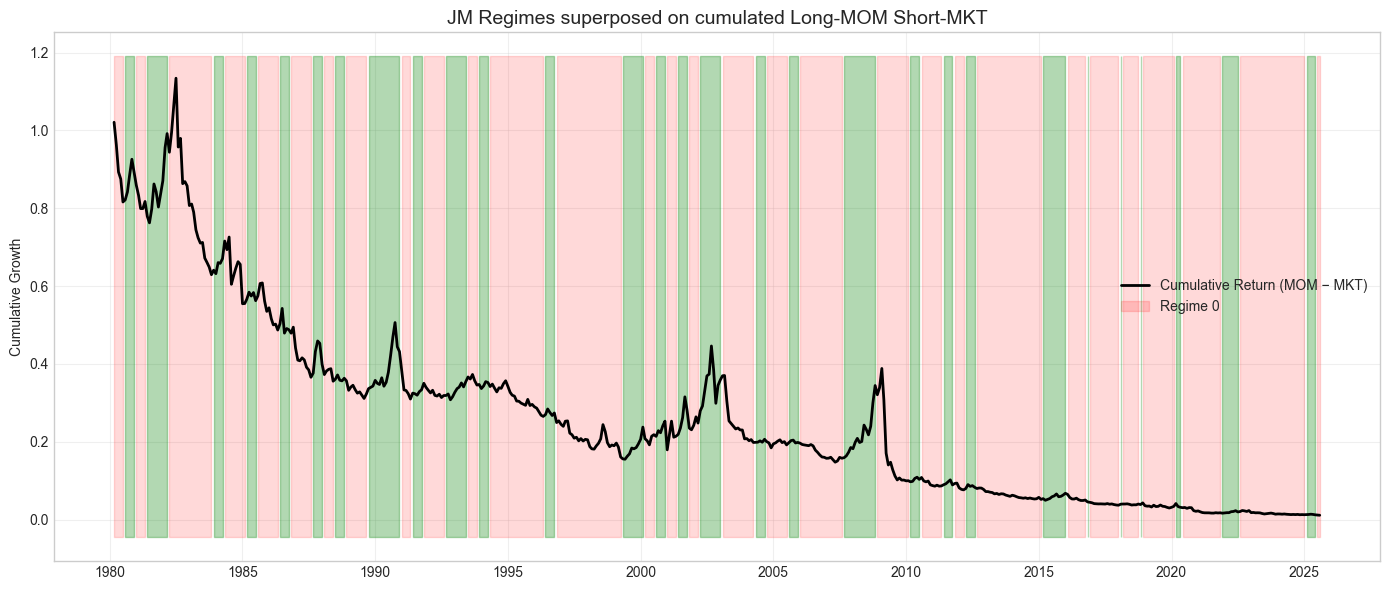

In [177]:
plot_jm_regimes_over_pnl(
    r_jm=r_jm,
    regimes=reg_all,
    title="JM Regimes superposed on cumulated Long-MOM Short-MKT"
)


In [178]:
fejzfjhbezf


NameError: name 'fejzfjhbezf' is not defined